#Install and test

In [2]:
!pip install mxnet --pre
from mxnet import nd


C:\Users\Anderson Lab\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
a = nd.ones((2,3))
b = a *2 +1
b.asnumpy()

array([[3., 3., 3.],
       [3., 3., 3.]], dtype=float32)

In [17]:
b


[[3. 3. 3.]
 [3. 3. 3.]]
<NDArray 2x3 @cpu(0)>

In [ ]:
#Creating Neural Network

In [6]:
from mxnet import nd
from mxnet.gluon import nn

In [8]:
net = nn.Sequential()
with net.name_scope():
    net.add(
        nn.Conv2D(channels=6, kernel_size=5,activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Conv2D(channels=16, kernel_size=3, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Flatten(),
        nn.Dense(120,activation='relu'),
        nn.Dense(84, activation='relu'),
        nn.Dense(10)
    )
net

Sequential(
  (0): Conv2D(None -> 6, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (2): Conv2D(None -> 16, kernel_size=(3, 3), stride=(1, 1))
  (3): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (4): Flatten
  (5): Dense(None -> 120, Activation(relu))
  (6): Dense(None -> 84, Activation(relu))
  (7): Dense(None -> 10, linear)
)

In [9]:
net. initialize()
x = nd.random.uniform(shape=(4,1,28,28))
y = net(x)
y.shape

(4, 10)

In [11]:
y


[[ 5.4206204e-04 -7.3721493e-04  1.4334248e-03  4.0265927e-03
  -1.4681303e-03 -7.2795294e-05 -2.3867751e-03  1.6901030e-03
   2.5573613e-03  2.5778799e-04]
 [-3.1755430e-05 -9.4792293e-04  1.9187334e-03  3.5630425e-03
  -1.0971474e-03 -7.7534199e-04 -1.4707050e-03  1.2286465e-03
   2.4597766e-03 -5.5741618e-04]
 [ 7.8960066e-04 -1.2167942e-03  2.1158289e-03  4.1428581e-03
  -1.2680317e-03  9.8977165e-05 -1.8518710e-03  9.5079106e-04
   2.4580581e-03 -2.5756948e-04]
 [ 1.1621228e-03 -5.1267102e-04  1.4823042e-03  3.8208610e-03
  -1.2394564e-03  2.2997717e-04 -2.2800716e-03  7.6769385e-04
   2.8567712e-03  3.0933262e-04]]
<NDArray 4x10 @cpu(0)>

#Implementing autograd (Automatic Gradient)

In [21]:
from mxnet import nd
from mxnet import autograd

In [23]:
x = nd.array([[1,2],[3,4]])
#initialize storage for gradients
x.attach_grad()
#create gradient function (will take derivative)
with autograd.record():
    y = 2 * x * x
y.backward()
x.grad


[[ 4.  8.]
 [12. 16.]]
<NDArray 2x2 @cpu(0)>

#Training a neural net

In [13]:
from mxnet import nd, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import datasets, transforms
import matplotlib.pyplot as plt
from time import time
import numpy as np

In [14]:
#get data
mnist_train = datasets.FashionMNIST(train=True)
X, y = mnist_train[0]

In [15]:
('X shape:', X.shape, 'X dtype', X.dtype, 'y:', y)

('X shape:', (28, 28, 1), 'X dtype', numpy.uint8, 'y:', 2)

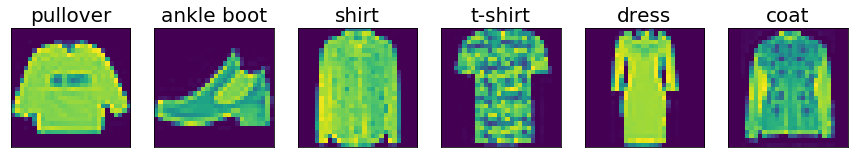

In [16]:
text_labels = ['t-shirt','trouser','pullover','dress','coat','sandal','shirt','sneaker','bag','ankle boot']
X, y = mnist_train[0:6]
# plot images
_, figs = plt.subplots(1, X.shape[0], figsize=(15, 15))
for f,x,yi in zip(figs, X,y):
    # 3D->2D by removing the last channel dim
    f.imshow(x.reshape((28,28)).asnumpy())
    ax = f.axes
    ax.set_title(text_labels[int(yi)])
    ax.title.set_fontsize(20)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [17]:
#uniform form of transform
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.13,0.31)])

mnist_train = mnist_train.transform_first(transformer)

In [18]:
batch_size = 256

train_data = gluon.data.DataLoader(
    mnist_train, batch_size=batch_size, shuffle=True, num_workers=0)

for data, label in train_data:
    print(data.shape, label.shape)
    break

(256, 1, 28, 28) (256,)


In [25]:
mnist_valid = gluon.data.vision.FashionMNIST(train=False)
valid_data = gluon.data.DataLoader(
    mnist_valid.transform_first(transformer),
    batch_size=batch_size, num_workers=0)

In [26]:
#initialize neural net
net = nn.Sequential()
with net.name_scope():
    net.add(
        nn.Conv2D(channels=6, kernel_size=5, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Conv2D(channels=16, kernel_size=3, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Flatten(),
        nn.Dense(120, activation="relu"),
        nn.Dense(84, activation="relu"),
        nn.Dense(10)
    )
net.initialize(init=init.Xavier())

In [27]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

In [28]:
trainer = gluon.Trainer(net.collect_params(),
                        'sgd', {'learning_rate': 0.1})

In [29]:
#Create a function to calculate accuracy
def acc(output, label):
    # output: (batch, num_output) float32 ndarray
    # label: (batch, ) int32 ndarray
    return (output.argmax(axis=1) ==
            label.astype('float32')).mean().asscalar()

In [30]:
#Training loop
for epoch in range(10):
    train_loss, train_acc, valid_acc = 0., 0., 0.
    tic = time()
    for data, label in train_data:
        # forward + backward
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        # update parameters
        trainer.step(batch_size)
        # calculate traing metrics
        train_loss += loss.mean().asscalar()
        train_acc += acc(output, label)

    # calculate validation accuracy
    for data, label in valid_data:
        valid_acc += acc(net(data), label)

    print("Epoch %d: Loss: %.3f, Train acc %.3f, Test acc %.3f, \
Time %.1f sec" % (
        epoch, train_loss/len(train_data),
        train_acc/len(train_data),
        valid_acc/len(valid_data), time()-tic))

Epoch 0: Loss: 0.792, Train acc 0.708, Test acc 0.820, Time 21.0 sec


Traceback (most recent call last):
  File "C:\Users\Anderson Lab\Anaconda3\lib\multiprocessing\queues.py", line 230, in _feed
    close()
  File "C:\Users\Anderson Lab\Anaconda3\lib\multiprocessing\connection.py", line 177, in close
    self._close()
  File "C:\Users\Anderson Lab\Anaconda3\lib\multiprocessing\connection.py", line 277, in _close
    _CloseHandle(self._handle)
OSError: [WinError 6] The handle is invalid


Epoch 1: Loss: 0.476, Train acc 0.823, Test acc 0.851, Time 21.0 sec
Epoch 2: Loss: 0.406, Train acc 0.851, Test acc 0.865, Time 21.7 sec
Epoch 3: Loss: 0.367, Train acc 0.865, Test acc 0.874, Time 21.3 sec
Epoch 4: Loss: 0.344, Train acc 0.874, Test acc 0.879, Time 20.9 sec
Epoch 5: Loss: 0.322, Train acc 0.881, Test acc 0.883, Time 21.0 sec
Epoch 6: Loss: 0.308, Train acc 0.886, Test acc 0.887, Time 20.9 sec
Epoch 7: Loss: 0.294, Train acc 0.891, Test acc 0.890, Time 20.9 sec
Epoch 8: Loss: 0.285, Train acc 0.894, Test acc 0.896, Time 21.0 sec
Epoch 9: Loss: 0.275, Train acc 0.898, Test acc 0.897, Time 20.9 sec


In [33]:
net.save_params('net.params')

Predict with our neural net :D

In [ ]:
from mxnet import nd
from mxnet import gluon
from mxnet.gluon import nn
from mxnet.gluon.data.vision import datasets, transforms
import matplotlib.pyplot as plt

In [ ]:
#Same as model that we trained with
net = nn.Sequential()
with net.name_scope():
    net.add(
        nn.Conv2D(channels=6, kernel_size=5, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Conv2D(channels=16, kernel_size=3, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Flatten(),
        nn.Dense(120, activation="relu"),
        nn.Dense(84, activation="relu"),
        nn.Dense(10)
    )

In [34]:
#load parameters (weights, etc.)
net.load_params('net.params')

In [35]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.13, 0.31)])

In [39]:
mnist_valid = datasets.FashionMNIST(train=False)
X, y = mnist_valid[6:13]
preds = []
for x in X:
    x = transformer(x).expand_dims(axis=0)
    pred = net(x).argmax(axis=1)
    preds.append(pred.astype('int32').asscalar())

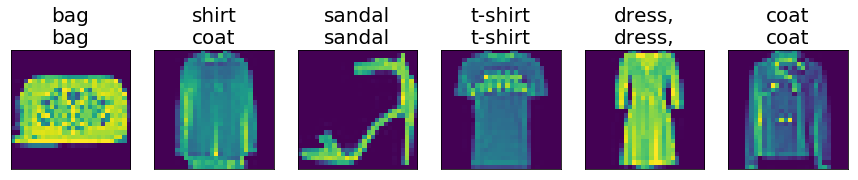

In [40]:
_, figs = plt.subplots(1, 6, figsize=(15, 15))
text_labels = [
    't-shirt', 'trouser', 'pullover', 'dress,', 'coat',
    'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot'
]
for f,x,yi,pyi in zip(figs, X, y, preds):
    f.imshow(x.reshape((28,28)).asnumpy())
    ax = f.axes
    ax.set_title(text_labels[yi]+'\n'+text_labels[pyi])
    ax.title.set_fontsize(20)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()